In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

import sklearn
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA # PCA
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # KNN

from sklearn import metrics
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.model_selection import KFold # K-fold validation
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
def z_score_normalization(df, cols):
    """Normalize a dataframe with specified columns

    Keyword arguments:
    df -- the input dataframe (pandas.DataFrame)
    cols -- the specified columns to be normalized (list)

    """
    train_set_normalized = df.copy()
    for col in cols:
        all_col_data = train_set_normalized[col].copy()
        #print(all_col_data)
        mu = all_col_data.mean()
        std = all_col_data.std()
        
        z_score_normalized = (all_col_data - mu) / std
        train_set_normalized[col] = z_score_normalized
    return train_set_normalized

In [4]:
""" Data input """
col_names = ['Index', 'Hogwarts House',	'First Name', 'Last Name', 'Birthday', 'Best Hand',	'Arithmancy', 'Astronomy', 'Herbology', 'Defense Against the Dark Arts', 'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic', 'Transfiguration', 'Potions', 'Care of Magical Creatures', 'Charms', 'Flying']
data = pd.read_csv('dataset_train.csv', sep=",", names=col_names, header=1)
data_viz = pd.read_csv('dataset_train.csv', sep=",", names=col_names, header=1)

""" Data preprocessing """
data = data.drop(columns=['Index', 'Birthday', 'First Name', 'Last Name', 'Best Hand']) # delete non-number features
data = data.dropna() # delete missing data

# shuffle
data = data.sample(frac=1)

# label encoding
labelencoder = LabelEncoder()
data['Hogwarts House'] = labelencoder.fit_transform(data['Hogwarts House'])

# normalization
col_names_norm = ['Arithmancy', 'Astronomy', 'Herbology', 'Defense Against the Dark Arts', 'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic', 'Transfiguration', 'Potions', 'Care of Magical Creatures', 'Charms', 'Flying']
data = z_score_normalization(data, col_names_norm)

# feature/label split
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [41]:
""" SVM """
# Linear
clf_lin = svm.SVC(kernel='linear').fit(X_train, y_train)

# Grid search (poly)
best_score = 0
best_degree = -1
best_gamma = 'auto'
best_coef0 = -1

scores_poly = np.zeros((5,5,12))
for i, gamma in enumerate(['scale', 'auto'] + [(i+1)*0.5 for i in range(3)]):
    for j, degree in enumerate([i+1 for i in range(5)]):
        for k, coef0 in enumerate([i*0.1 for i in range(12)]):
            clf_poly = svm.SVC(kernel='poly', degree=degree, gamma=gamma, coef0=coef0)
            scores = cross_val_score(clf_poly,X_train,y_train,cv=5,scoring='accuracy')
            scores_poly[i][j][k] = scores.mean()
            if scores.mean() > best_score:
                best_score = scores.mean()
                best_degree = degree
                best_gamma = gamma
                best_coef0 = coef0
print('Grid search finish!')
print(best_degree, best_gamma, best_coef0)
print('Best score = ', best_score)

clf_poly = svm.SVC(kernel='poly', degree=best_degree, gamma=best_gamma, coef0=best_coef0)
clf_poly.fit(X_train, y_train)

Grid search finish!
1 scale 0.0
Best score =  0.9828571428571429


SVC(degree=1, kernel='poly')

In [78]:
""" Logistic regression """
clf_logi = LogisticRegression(random_state=0).fit(X_train, y_train)

In [88]:
""" KNN """
clf_knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [90]:
""" Results """

label_names = labelencoder.inverse_transform([0,1,2,3])

# SVM
y_pred = clf_poly.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_names))

# Logistic
y_pred2 = clf_logi.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2, target_names=label_names))

# KNN
y_pred3 = clf_knn.predict(X_test)
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3, target_names=label_names))

[[ 78   0   0   0]
 [  0 121   0   0]
 [  0   1 108   0]
 [  0   1   0  66]]
              precision    recall  f1-score   support

  Gryffindor       1.00      1.00      1.00        78
  Hufflepuff       0.98      1.00      0.99       121
   Ravenclaw       1.00      0.99      1.00       109
   Slytherin       1.00      0.99      0.99        67

    accuracy                           0.99       375
   macro avg       1.00      0.99      0.99       375
weighted avg       0.99      0.99      0.99       375

[[ 78   0   0   0]
 [  0 121   0   0]
 [  0   1 108   0]
 [  0   1   0  66]]
              precision    recall  f1-score   support

  Gryffindor       1.00      1.00      1.00        78
  Hufflepuff       0.98      1.00      0.99       121
   Ravenclaw       1.00      0.99      1.00       109
   Slytherin       1.00      0.99      0.99        67

    accuracy                           0.99       375
   macro avg       1.00      0.99      0.99       375
weighted avg       0.99      0.

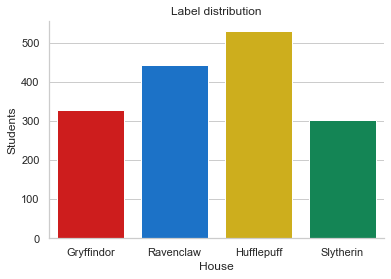

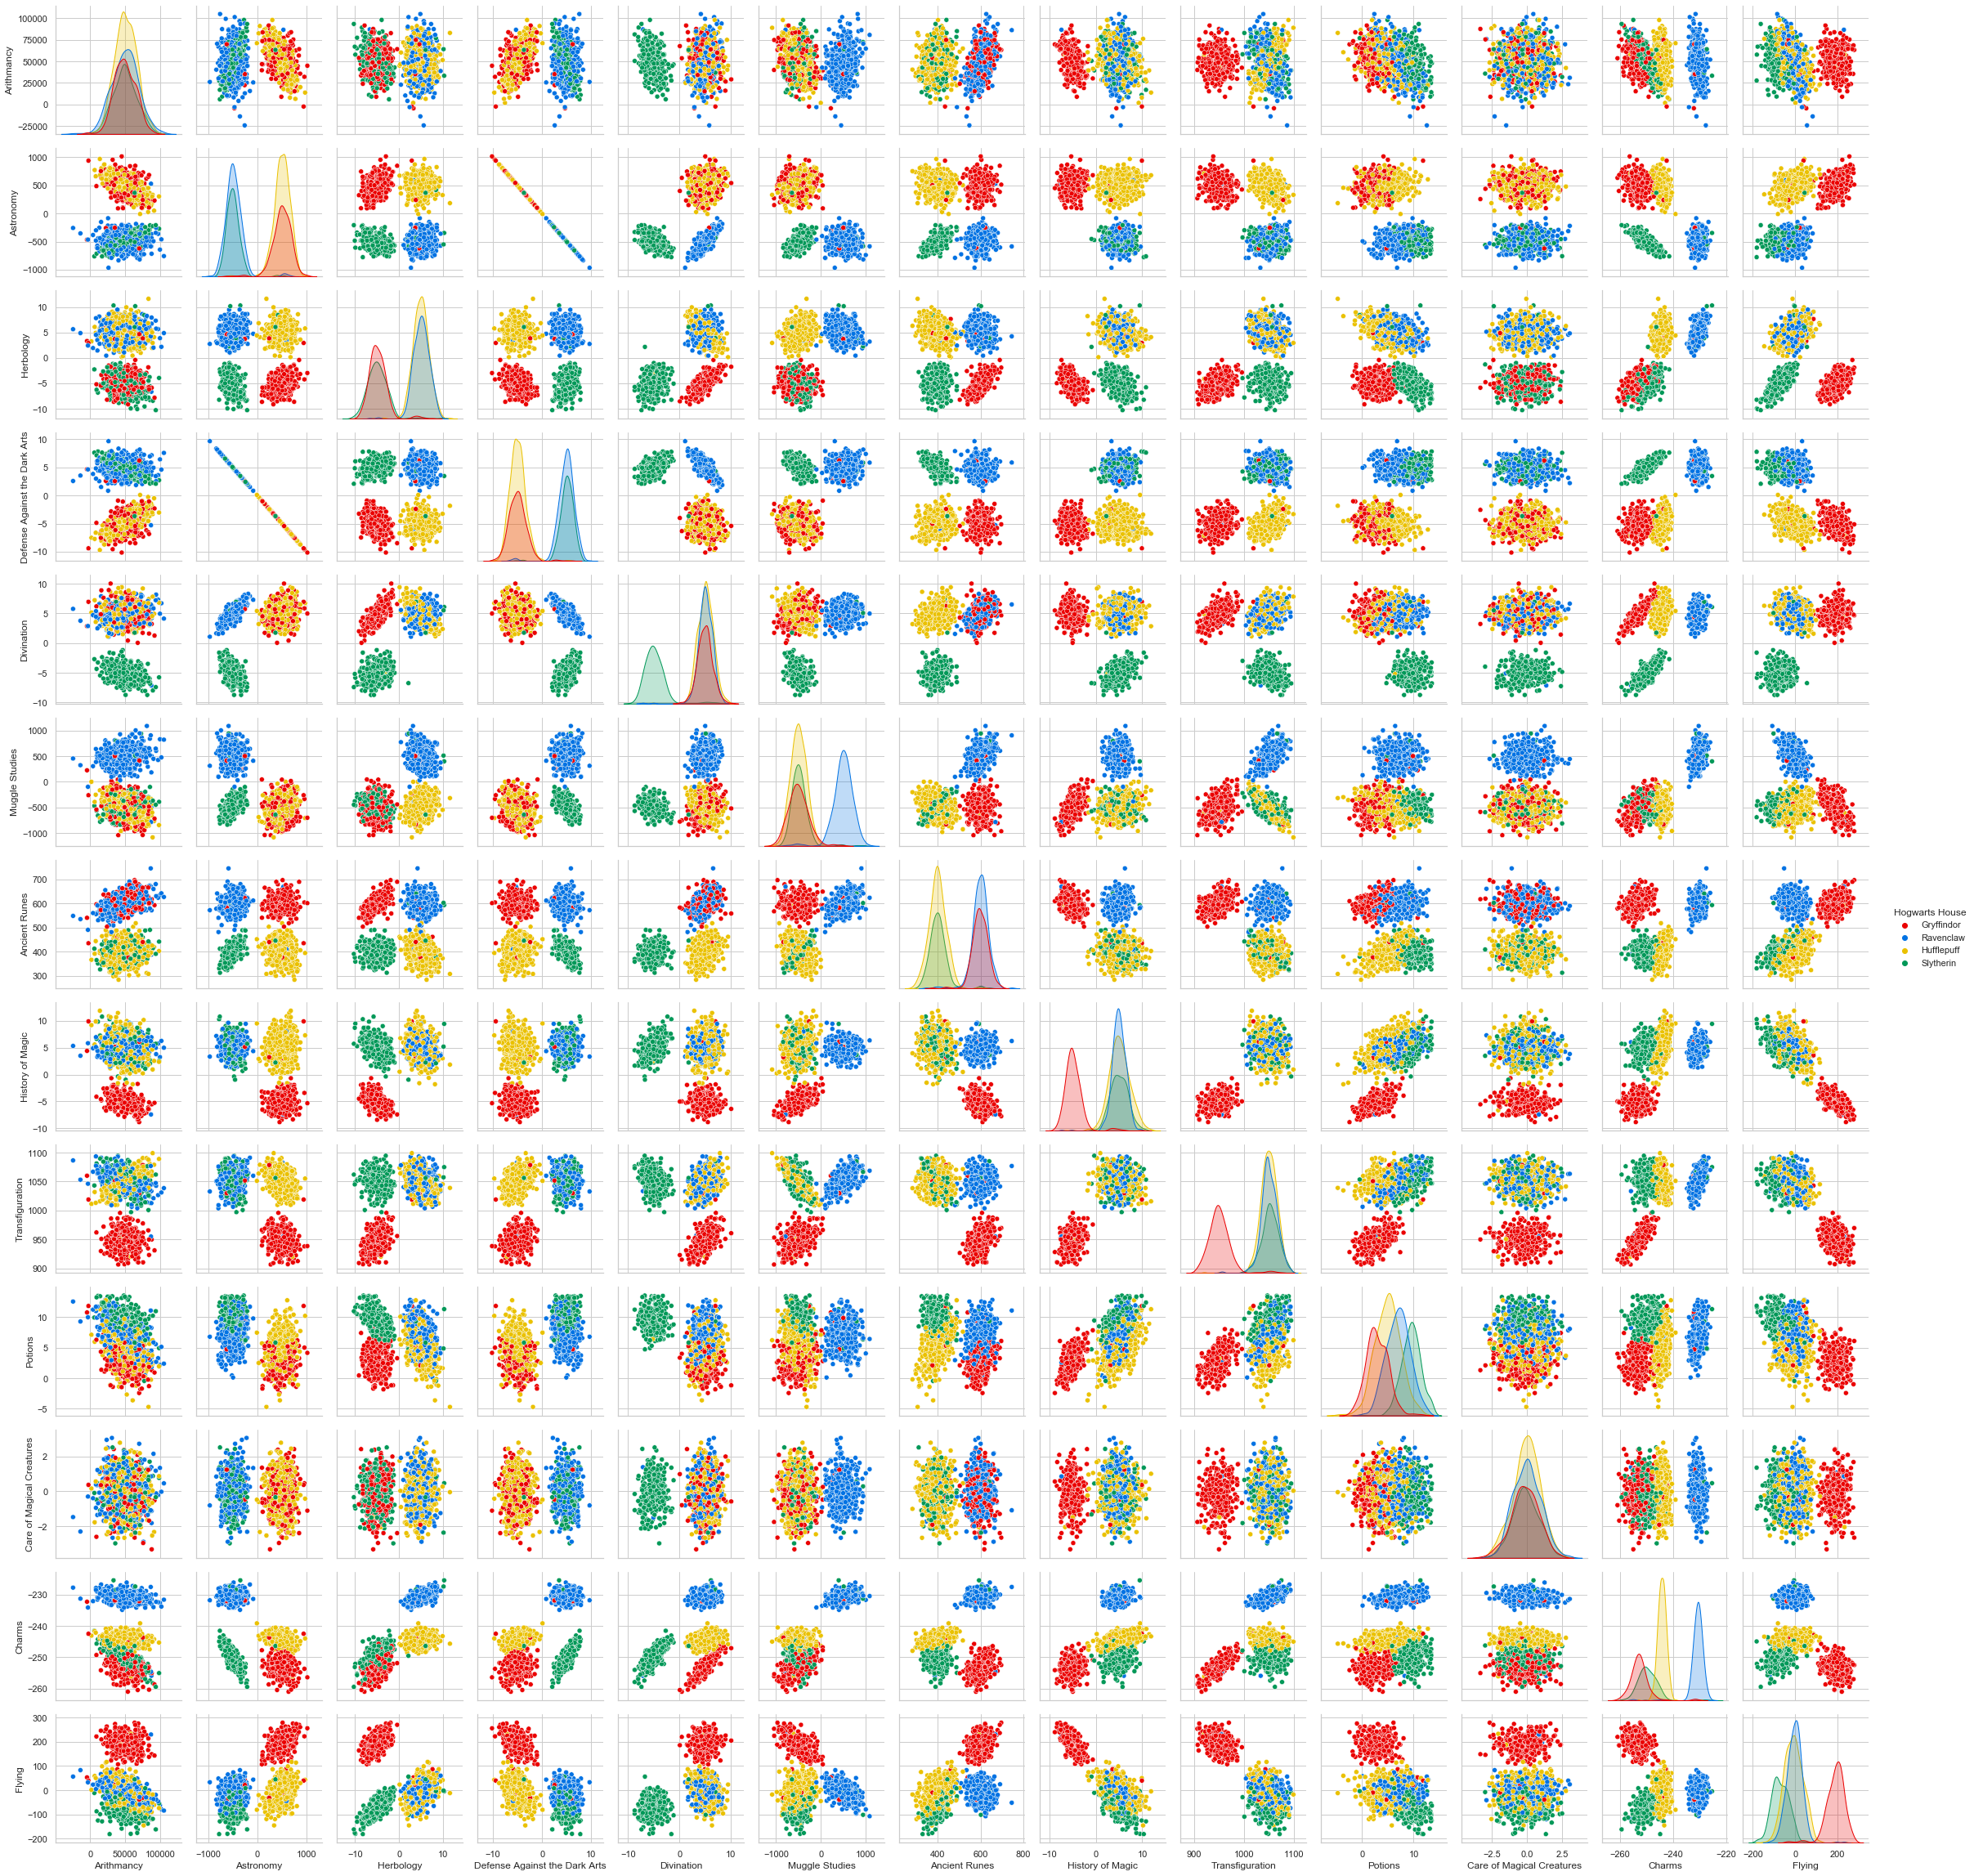

In [9]:
""" Data Visualization """

# value count of 4 labels
vc_label = data_viz['Hogwarts House'].value_counts()

plt.title("Label distribution")
plt.xlabel("House")
plt.ylabel("Students")
sns.despine(top = True, right = True) # 移除上方跟右方的框線 
sns.set(style = "whitegrid") # 白色網格背景
c = ["#EA0000", "#0072E3", "#EAC100", "#019858"]
pal = sns.color_palette(c)
houses = ['Gryffindor', 'Ravenclaw', 'Hufflepuff', 'Slytherin']
sns.barplot(x=houses, y=[vc_label[house] for house in houses], palette=pal)
plt.show()

# pair plot
img = sns.pairplot(data_viz.drop(columns=['Index', 'Birthday', 'First Name', 'Last Name', 'Best Hand']), hue='Hogwarts House', hue_order=houses, palette=pal)
img.savefig('pairplot.png')
plt.show()